In [ ]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot

import numpy as np

In [ ]:
# https://www.kaggle.com/datasets/thaile1001/corona0221202
# 데이터 수집 & 로드
# 전세계 지역별 확진자, 회복자, 사망자 Data Set
url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv'
data = pd.read_csv(url, error_bad_lines=False)

# Data Set의 구조 파악
data.head()

<ipython-input-4-44503a520d4b>:5: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.





,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,0,0.0,0
1,2020-01-23,Afghanistan,NaN,0,0.0,0
2,2020-01-24,Afghanistan,NaN,0,0.0,0
3,2020-01-25,Afghanistan,NaN,0,0.0,0
4,2020-01-26,Afghanistan,NaN,0,0.0,0


In [ ]:
# 한국의 확진자 시계열 데이터프레임 확인

df_korea = data[data['Country/Region'] == 'Korea, South']

df_korea = np.column_stack([df_korea.Date, df_korea.Confirmed])
df_korea =  pd.DataFrame(df_korea)

df_korea = df_korea.reset_index().rename(columns={0: 'date', 1: 'confirmed'})
df_korea = df_korea.drop("index", axis=1)

# df_korea = df_korea.append([
#   {'date': pd.to_datetime('2020-03-22'), 'confirmed': 8,897}], ignore_index=True)

df_korea.tail()

,date,confirmed
811,2022-04-12,15830644
812,2022-04-13,15979061
813,2022-04-14,16104869
814,2022-04-15,16212751
815,2022-04-16,16305752


In [ ]:
# 한국 코로나19 확진자 트렌드를 그래프로 만듭니다.

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_korea.date,
        y=df_korea.confirmed,
        name='Confirmed in Korea'
    )
)

fig


In [ ]:
# Facebook Prophet 예측 모델에 넣을 데이터프레임 생성
df_prophet = df_korea.rename(columns={
    'date': 'ds',
    'confirmed': 'y'
})

df_prophet.tail()

,ds,y
811,2022-04-12,15830644
812,2022-04-13,15979061
813,2022-04-14,16104869
814,2022-04-15,16212751
815,2022-04-16,16305752


In [ ]:
# https://facebook.github.io/prophet/docs/trend_changepoints.html
# Prophet에서 감안할 계절성을 선택해서 모델 생성
m = Prophet(
    changepoint_prior_scale=0.2, # increasing it will make the trend more flexible
    changepoint_range=0.9, # place potential changepoints in the first 98% of the time series
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True,
    seasonality_mode='additive' # 경향이 더해지는, 곱해지는 형태일 떄는 multiplecative
)

m.fit(df_prophet)

future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
py.iplot(fig)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp042fnq9x/ph5lazmc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp042fnq9x/osxw_x5o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52091', 'data', 'file=/tmp/tmp042fnq9x/ph5lazmc.json', 'init=/tmp/tmp042fnq9x/osxw_x5o.json', 'output', 'file=/tmp/tmp042fnq9x/prophet_modelv241id7k/prophet_model-20231012173347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


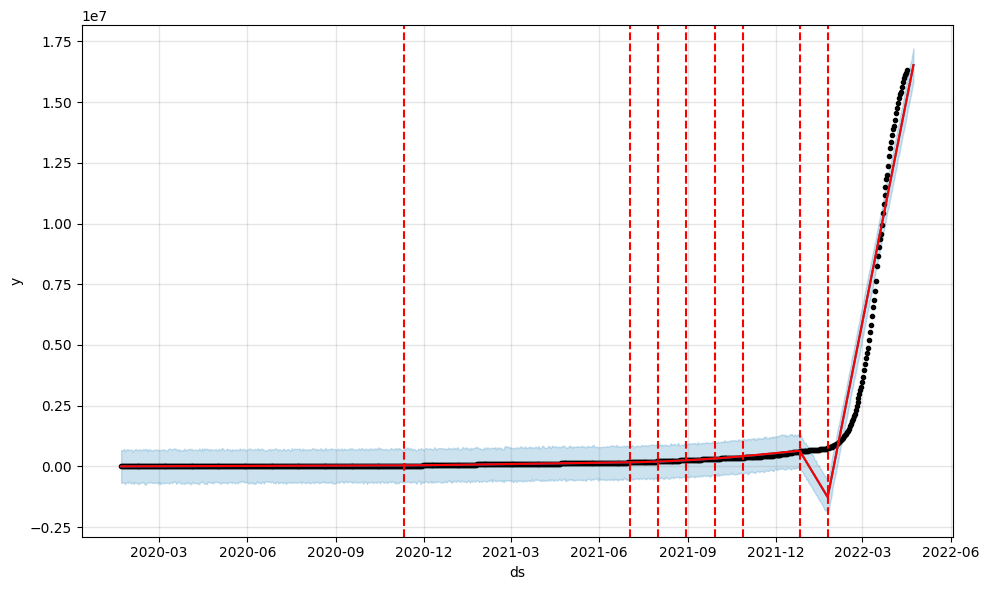

In [ ]:
# Plot changepoints
# changepoint를 그래프에 반영
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)